# Goemans-Williamson algorithm for Maxcut problem

In [20]:
import networkx as nx
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns

## Graph generation

In [21]:
def generate_random_graph(n_nodes=8, p=0.5, seed=None):
    """
    Generates a random undirected weighted graph using the Erdős-Rényi model.
    """
    G = nx.erdos_renyi_graph(n_nodes, p, seed=seed)
    for (u, v) in G.edges():
        G.edges[u, v]['weight'] = np.random.randint(1, 10)
    return G

## Algorithm

In [22]:
def goemans_williamson_maxcut(G, num_rounds=50, seed=None):
    np.random.seed(seed)
    n = G.number_of_nodes()
    W = nx.to_numpy_array(G, weight='weight')
    
    # SDP relaxation
    X = cp.Variable((n, n), symmetric=True)
    constraints = [X >> 0, cp.diag(X) == 1]
    objective = cp.Maximize(0.25 * cp.sum(cp.multiply(W, 1 - X)))
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS, verbose=False)
    X_opt = X.value

    # Randomized hyperplane rounding
    vals, vecs = np.linalg.eigh(X_opt)
    V = vecs @ np.diag(np.sqrt(np.maximum(vals, 0)))
    best_cut = None
    best_value = -np.inf
    for _ in range(num_rounds):
        r = np.random.randn(n)
        r /= np.linalg.norm(r)
        assignment = V @ r > 0
        cut_value = 0
        for i, j in G.edges():
            if assignment[i] != assignment[j]:
                cut_value += G.edges[i, j]['weight']
        if cut_value > best_value:
            best_value = cut_value
            best_cut = assignment
    return best_cut, best_value

## Test of functionality

Best cut value: 54


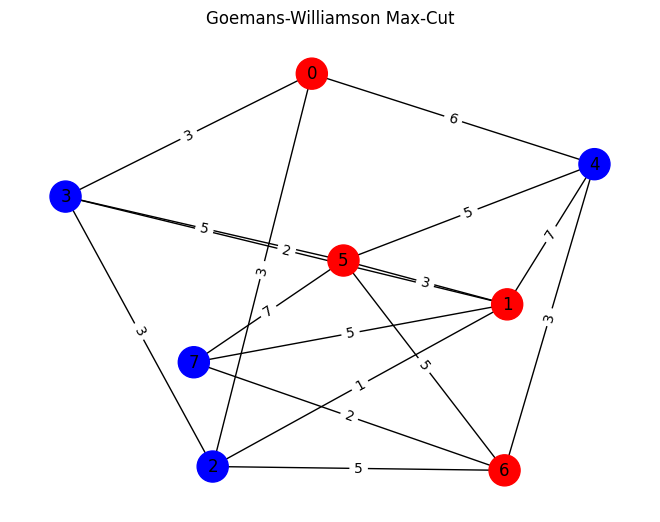

In [23]:
G = generate_random_graph(n_nodes=8, p=0.5, seed=42)
cut, value = goemans_williamson_maxcut(G, num_rounds=100, seed=42)
print(f"Best cut value: {value}")

def plot_cut(G, cut):
    pos = nx.spring_layout(G, seed=42)
    colors = ['red' if cut[node] else 'blue' for node in G.nodes()]
    nx.draw(G, pos, with_labels=True, node_color=colors, node_size=500)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.title("Goemans-Williamson Max-Cut")
    plt.show()

plot_cut(G, cut)

In [ ]:
def run_gw_experiment(sizes, edge_prob=0.5, target_time=420.0):
    all_cut_values = []
    all_times = []
    for idx, n_nodes in enumerate(sizes):
        G = generate_random_graph(n_nodes=n_nodes, p=edge_prob, seed=idx)
        cut_values = []
        run_times = []
        start_time = time.time()
        while time.time() - start_time < target_time:
            t0 = time.time()
            cut, value = goemans_williamson_maxcut(G, num_rounds=50)
            t1 = time.time()
            cut_values.append(value)
            run_times.append(t1 - t0)
        all_cut_values.append(cut_values)
        all_times.append(run_times)
        print(f"Size: {n_nodes} | Runs: {len(cut_values)} | Best Cut: {max(cut_values)} | Total Time: {sum(run_times):.1f}s")
    return all_cut_values, all_times

sizes = [25, 50, 75, 100, 125, 150, 175, 200]
cut_values, run_times = run_gw_experiment(sizes, edge_prob=0.5, target_time=300.0)

df = pd.DataFrame({
    'Graph Size': sum([[size]*len(vals) for size, vals in zip(sizes, cut_values)], []),
    'Cut Value': sum(cut_values, [])
})

plt.figure(figsize=(10,6))
sns.violinplot(x='Graph Size', y='Cut Value', data=df, inner='quartile', scale='width')
plt.title('Goemans-Williamson Max-Cut Performance')
plt.xlabel('Graph Size (nodes)')
plt.ylabel('Cut Value')
plt.show()

Size: 25 | Runs: 4334 | Best Cut: 518 | Total Time: 300.0s
Size: 50 | Runs: 790 | Best Cut: 1855 | Total Time: 300.2s
Size: 75 | Runs: 231 | Best Cut: 4106 | Total Time: 301.2s
Size: 100 | Runs: 80 | Best Cut: 7448 | Total Time: 302.5s
Size: 125 | Runs: 40 | Best Cut: 11489 | Total Time: 306.7s
Size: 150 | Runs: 28 | Best Cut: 16092 | Total Time: 306.8s
Size: 175 | Runs: 17 | Best Cut: 21643 | Total Time: 306.4s
Size: 200 | Runs: 11 | Best Cut: 28521 | Total Time: 326.2s
Size: 225 | Runs: 9 | Best Cut: 35773 | Total Time: 314.3s


In [ ]:
df.to_csv("gw_experiment_results.csv", index=False)